<a href="https://colab.research.google.com/github/sganguly3000ai/makemore/blob/main/makemore_05_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bigram character level language model using neural network MLP Wavenet**

In [59]:
import torch
import numpy as np
import string
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
%matplotlib inline


In [61]:
# the yob1996.txt file is locally stored in the downloads/names directory
# and should be uploaded to the sample_data directory in colab before running
# create a list of words or names

# create a list of words or names

names   = np.loadtxt('sample_data/yob1996.txt', delimiter=',', usecols = 0, dtype = str)
lnames  = np.char.lower(names)
words  = pd.unique(lnames)



In [62]:
print(f'{names[:8]} :Shape = {names.shape}\n{lnames[:8]} :Shape = {lnames.shape}\n{words[:8]} :Shape = {words.shape}')


['Emily' 'Jessica' 'Ashley' 'Sarah' 'Samantha' 'Taylor' 'Hannah' 'Alexis'] :Shape = (26426,)
['emily' 'jessica' 'ashley' 'sarah' 'samantha' 'taylor' 'hannah' 'alexis'] :Shape = (26426,)
['emily' 'jessica' 'ashley' 'sarah' 'samantha' 'taylor' 'hannah' 'alexis'] :Shape = (24306,)


In [63]:
# create a dictionary of the lowercase english alphabets + '.' as the start and end character for a word

chars = list(string.ascii_lowercase)
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size=len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [64]:
# build the dataset

#block_size = 3 # context length: how many characters do we take to predict the next one?
block_size = 8 # context length: how many characters do we take to predict the next one?
def build_dataset(words):
  X, Y = [],[]


  for w in words:
    context = [0] * block_size

    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '---->', itos[ix])
      context = context[1:] + [ix] #crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape,Y.shape)
  return X, Y

np.random.seed(42)
np.random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# train,dev and test datasets (80,10,10)
Xtr, Ytr        =  build_dataset(words[:n1])
Xdev, Ydev      =  build_dataset(words[n1:n2])
Xtest, Ytest    =  build_dataset(words[n2:])


torch.Size([142863, 8]) torch.Size([142863])
torch.Size([17771, 8]) torch.Size([17771])
torch.Size([17942, 8]) torch.Size([17942])


In [65]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> c
.......c ---> i
......ci ---> n
.....cin ---> d
....cind ---> y
...cindy ---> .
........ ---> a
.......a ---> u
......au ---> d
.....aud ---> r
....audr ---> i
...audri ---> a
..audria ---> n
.audrian ---> n
audriann ---> a
udrianna ---> .
........ ---> k
.......k ---> a
......ka ---> t
.....kat ---> r


In [150]:
# ---------------------------------------------------------------------------------------

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight   = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias     = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# ---------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps        = eps
    self.momentum   = momentum
    self.training   = True
    # parameters trained with backprop
    self.gamma      = torch.ones(dim)
    self.beta       = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var  = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean         = x.mean(0, keepdim=True)                   # batch mean
      xvar          = x.var(0, keepdim=True, unbiased=True)     # batch variance
    else:
      xmean         = self.running_mean
      xvar          = self.running_var
    xhat            = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out        = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean   = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var    = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]
# ---------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out       = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
# ---------------------------------------------------------------------------------------
class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn(num_embeddings, embedding_dim)

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]
# ---------------------------------------------------------------------------------------
class FlattenConsecutive:
  def __init__(self,n):
    self.n = n

  def __call__(self,x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  def parameters(self):
    return []
# ---------------------------------------------------------------------------------------
class Sequential:   # container class
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and strech them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [199]:
torch.manual_seed(42); # seed rng (random number generator for reproducibility

In [200]:
n_embd       = 10                                         # the dimensionality of the character embedding vectors
n_hidden    = 68                                 # the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size,n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])


with torch.no_grad():
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))               # number of parameters in total
for p in parameters:
  p.requires_grad = True


22397


In [191]:
n_embd       = 10                                         # the dimensionality of the character embedding vectors
n_hidden    = 200                                      # the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size,n_embd),
    FlattenConsecutive(block_size), Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
])


with torch.no_grad():
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))               # number of parameters in total
for p in parameters:
  p.requires_grad = True

22097


In [197]:
  ix = torch.randint(0, Xtr.shape[0], (4,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  print(Xb.shape)
  print(logits.shape)

torch.Size([4, 8])
torch.Size([4, 27])


In [198]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))
  # if layer.__class__.__name__ == 'FlattenConsecutive':
  #   print(layer.B, layer.T//layer.n,layer.C, layer.y, layer.sq,layer.z)

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [201]:
# same optimization as last time

max_steps       = 200000
batch_size      = 32
lossi           = []

for i in range(max_steps):

  # minibatch construct (pluck bath_size samples out of the total number of samples randomly
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)      # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 100000 else .01         # step learning rate decay
  for p in parameters:
    p.data   += -lr * p.grad

  # track stats
  if i % 10000 == 0:                      # print every 10000 iterations
    print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
  lossi.append(loss.log10().item())



      0/ 200000: 3.284716
  10000/ 200000: 2.056566
  20000/ 200000: 1.741141
  30000/ 200000: 1.606953
  40000/ 200000: 1.701215
  50000/ 200000: 2.073834
  60000/ 200000: 2.237099
  70000/ 200000: 1.633628
  80000/ 200000: 2.001666
  90000/ 200000: 1.657913
 100000/ 200000: 2.238037
 110000/ 200000: 1.740681
 120000/ 200000: 1.763701
 130000/ 200000: 2.199158
 140000/ 200000: 2.051473
 150000/ 200000: 2.120688
 160000/ 200000: 1.718962
 170000/ 200000: 2.110086
 180000/ 200000: 1.927316
 190000/ 200000: 1.901210


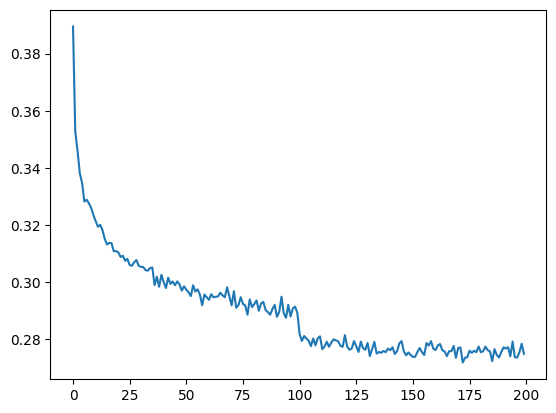

In [202]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [203]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [204]:
# run to evaluate what the train and validation data is showing as per as the loss

@torch.no_grad()                                # this decorator disables gradient tracking
def split_loss(split):
  x,y = {'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xtest, Ytest),
        }[split]

  # forward pass
  logits = model(x)
  # emb       = C[x]                          # embed the characters into vectors
  # x         = emb.view(emb.shape[0], -1)  # concatenate the vectors
  # for layer in layers:
  #   x = layer(x)
  #loss = F.cross_entropy(x, y)      # loss function
  loss = F.cross_entropy(logits, y)      # loss function

  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8577371835708618
val 1.9769911766052246


In [207]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(30):

  out = []
  context = [0]*block_size # initialize with all '...'
  while True:

    logits = model(torch.tensor([context]))
    probs   = F.softmax(logits, dim=1)

    # sample from the distribution
    ix      = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]

    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))


montaimha.
zacel.
nichyla.
teverscondra.
gradee.
deelin.
shyloe.
ledeisea.
anastery.
kortney.
nyshub.
roshiann.
tyleisha.
jeran.
colfino.
macderiya.
lezeh.
yuma.
mysteyan.
halica.
yansun.
zakel.
julena.
revis.
jaisha.
fadin.
quine.
bangpeic.
shauna.
chhundra.
